# Transfer learning with TensorFlow Part 1: Feature extraction

Transfer learning is leveraging a working's model existing architecture and learned patterns for our own problems.

The main benefits are:
1. Can leverage an exisitng neural network architecture proven to work on problems similar to ours
2. Can leverage a working a neural network architecture that has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [1]:
# Are we using a GPU?
!nvidia-smi

zsh:1: command not found: nvidia-smi


## Download and become one with the data

In [4]:
# Get data (10% of 10 food classes from Food101)
import zipfile
wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

SyntaxError: invalid syntax (4143832615.py, line 3)

In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list fiels
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 10 director

## Create the data loaders (preparing the data)
We're goint to use `ImageDataGenerator` class to load in our images in batches.

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training images: 
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Callbacks are extra functionalities you can add to you models to be performed during or after training. Some of most popular ones are:
* Tracking experiments with TensorBoard callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training (before trains too long or overfits) with the EarlyStop callback

In [6]:
# Create TensorBoard callback (functionize because we need a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard files to: {log_dir}")
  return tensorboard_callback

> **NOTE:** You can customize where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` as above is only one option.

## Creating model using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch. 

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev

Browsing rhe TensorFlow Hub page and sorting for image classification, we've found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [7]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [8]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url (str): A TensorFlow Hub feature extraction URL
  num_classes (int): Number of output neurons in the output layer, 
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer with Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url, 
                                           trainable=False, # freeze the already trained patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model                          

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [10]:
# Create ResNet model
resnet_model = create_model(resnet_url, 
                            num_classes=train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# Compile our ResNet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='Adam',
                     metrics=['accuracy'])

In [13]:
# Fit the data to pretrained model
resnet_history = resnet_model.fit(train_data_10_percent, 
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub_1', 
                                                                         experiment_name='resnetV2_50'
                                                                         )])

Saving TensorBoard files to: tensorflow_hub_1/resnetV2_50/20230131-163850
Epoch 1/5
24/24 [==============================] - 30s 784ms/step - loss: 1.9019 - accuracy: 0.3453 - val_loss: 1.1988 - val_accuracy: 0.6088
Epoch 2/5
24/24 [==============================] - 16s 682ms/step - loss: 0.9101 - accuracy: 0.7333 - val_loss: 0.8608 - val_accuracy: 0.7200
Epoch 3/5
24/24 [==============================] - 16s 679ms/step - loss: 0.6350 - accuracy: 0.8173 - val_loss: 0.7377 - val_accuracy: 0.7648
Epoch 4/5
24/24 [==============================] - 16s 678ms/step - loss: 0.4820 - accuracy: 0.8707 - val_loss: 0.6904 - val_accuracy: 0.7740
Epoch 5/5
24/24 [==============================] - 16s 681ms/step - loss: 0.3966 - accuracy: 0.9000 - val_loss: 0.6705 - val_accuracy: 0.7760


In [14]:
resnet_model.evaluate(test_data)[0]

79/79 [==============================] - 12s 155ms/step - loss: 0.6705 - accuracy: 0.7760


0.6705003976821899

Wow!

That is incredible. Our transfer learning feature extractor model out performed ALL of our previous models we've built by hand. Substantially.

And in way quicker training time. And with only 10% of the training examples.

In [15]:
# Let's create a function to plot loss curves
def plot_loss_curves(history):
  """
  Plotting the loss curves given the history of a model.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

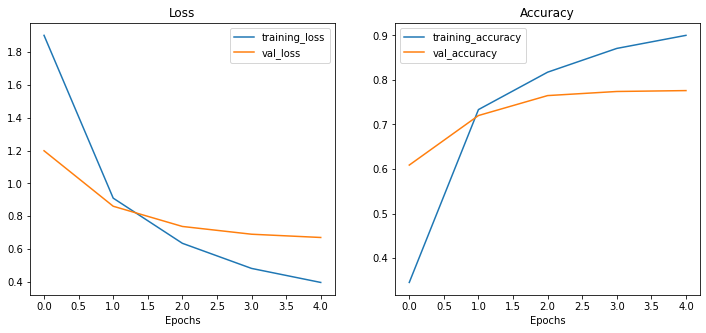

In [16]:
plot_loss_curves(history=resnet_history)

### Creating and testing EfficientNet B0 TensorFlow Hub Feature Extraction model

In [17]:
# Creating a EfficientNet B0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile the EfficientNet B0 model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])
# Fit the EfficientNet B0 model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=15, 
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub_1',
                                                                                      experiment_name='efficientnet_b0'
                                                                                      )])

Saving TensorBoard files to: tensorflow_hub_1/efficientnet_b0/20230131-164051
Epoch 1/15
24/24 [==============================] - 26s 747ms/step - loss: 1.8737 - accuracy: 0.4427 - val_loss: 1.2991 - val_accuracy: 0.7440
Epoch 2/15
24/24 [==============================] - 24s 1s/step - loss: 1.0738 - accuracy: 0.7893 - val_loss: 0.8580 - val_accuracy: 0.8172
Epoch 3/15
24/24 [==============================] - 15s 632ms/step - loss: 0.7597 - accuracy: 0.8427 - val_loss: 0.6888 - val_accuracy: 0.8456
Epoch 4/15
24/24 [==============================] - 15s 635ms/step - loss: 0.6128 - accuracy: 0.8693 - val_loss: 0.6085 - val_accuracy: 0.8520
Epoch 5/15
24/24 [==============================] - 15s 638ms/step - loss: 0.5145 - accuracy: 0.8880 - val_loss: 0.5535 - val_accuracy: 0.8612
Epoch 6/15
24/24 [==============================] - 15s 632ms/step - loss: 0.4486 - accuracy: 0.9067 - val_loss: 0.5210 - val_accuracy: 0.8660
Epoch 7/15
24/24 [==============================] - 15s 627ms/step 

In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


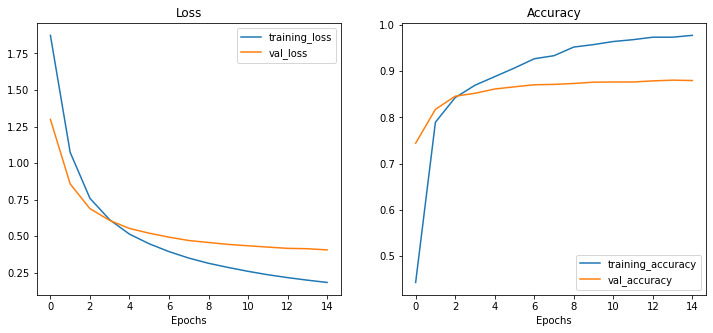

In [19]:
plot_loss_curves(efficientnet_history)

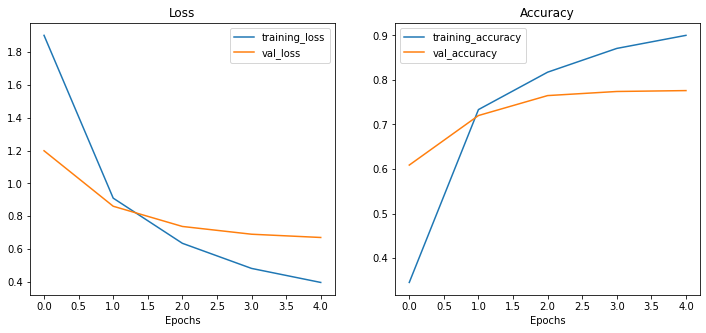

In [20]:
plot_loss_curves(resnet_history)

## Different types of transfer learning

* **'As is'** transfer learning - using an existing model with no changes whatsoever(e.g using ImageNet model on a 1000 ImageNet classes)
* **'Feature Extraction'** transfer learning - using the prelearned patterns of an existing model (e.g EfficientNet B0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 on ImageNet -> 10 classes of food)
* **'Fine tuning'** transfer learning - use the prelearned patterns of an existing model nad fine-tune many or all of the underlaying layers

In [20]:
# How many layers does our EfficientNet B0 model have?
len(efficientnet_model.layers[0].weights)

309

## Comparing model results using TensorBoard

> **NOTE:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments - do not upload them do TensorBoard.dev.

In [23]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub_1/ \
 --name "EfficientNet B0 vs ResNet50V2" \
 --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
 --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub_1/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=K7567qbSm4GnaPQTQLNymIDvCQjBh5&prompt=consent&access_type=o

In [25]:
# Check out what TensorBoard experiments we have
!tensorboard dev list

https://tensorboard.dev/experiment/HjAekIbJTjOBpeaXcDozKA/
	Name                 EfficientNet B0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   HjAekIbJTjOBpeaXcDozKA
	Created              2023-01-30 21:19:44 (5 minutes ago)
	Updated              2023-01-30 21:19:46 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  5794895
Total: 1 experiment(s)


In [28]:
# Delete and experiment
!tensorboard dev delete --experiment_id HjAekIbJTjOBpeaXcDozKA

Deleted experiment HjAekIbJTjOBpeaXcDozKA.


In [29]:
# Confirm deletion looking at the list again
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
